# OBJECT DETECTION IA 
## (Classification only -> No localisation) 
### DeepLearning Network using CNN transfert learning with a classifier that I add
### The goal is to detect human body in a video-surveillance cam

# DATA
## Import

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import torch
from torchvision import datasets, transforms

import helper #pymodule that I add to print image from dataloader

## Download 
###### Do not re-execute this cell

In [6]:
#DO NOT RE-EXECUTE THIS CELL

#Download kaggle dataset
!kaggle datasets download -p "data/raw" --unzip --force constantinwerner/human-detection-dataset/version/3



^C


## Transform & LOAD data
we doesn't have to transform much the data, all images are already 256*256 px

In [4]:
data_dir = "data/kaggle_ConstantinWerner"

#transform
transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                #transforms.Grayscale(),
                                transforms.ToTensor()])
#maybe add normalisation -> transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5]) 
                                                            

#load (with ImageFolder)
train_dataset = datasets.ImageFolder(data_dir + "/train", transform=transform)
test_dataset = datasets.ImageFolder(data_dir + "/test", transforms.ToTensor())

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=20, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=20, shuffle=True)

#### Show an image

images type :  torch.Size([20, 3, 256, 256])
labels type :  torch.Size([20])


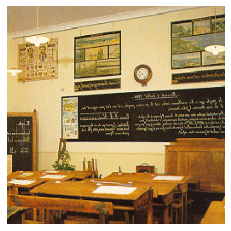

In [5]:
images, labels = next(iter(train_dataloader))

helper.imshow(images[2], normalize=False)

print("images type : ", images.shape)
print("labels type : ", labels.shape)

## Transform and Load VALICA dataset

In [292]:
data_dir2 = "data/homemade_Valica"

#transform
transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(256),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()])
#maybe add normalisation -> transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5]) 
                                                            

#load (with ImageFolder)
test_valica_dataset = datasets.ImageFolder(data_dir2, transform=transform)

test_valica_dataloader = torch.utils.data.DataLoader(test_valica_dataset, batch_size=20, shuffle=True)

#### Show an image

images type :  torch.Size([20, 3, 256, 256])
labels type :  torch.Size([20])


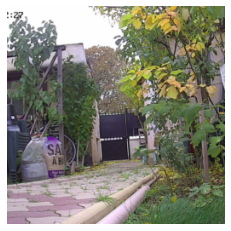

In [293]:
images, labels= next(iter(test_valica_dataloader))

helper.imshow(images[0], normalize=False)

print("images type : ", images.shape)
print("labels type : ", labels.shape)

# MODEL

## Import

In [280]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import models

from collections import OrderedDict

## Load pretrained model

In [317]:
model = models.densenet121(pretrained=True)

## Create classifier

In [320]:
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(1024,512)),
    ('relu', nn.ReLU()),
    ('dropout', nn.Dropout(0.2)),
    ('fc2',nn.Linear(512,2)),
    ('output', nn.LogSoftmax(dim=1))
    ]))

criterion = nn.NLLLoss()

#Add our classifier to our pretrained network
model.classifier = classifier

## Train model
### Pre-train

In [323]:
#GPU available ?
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Train on GPU")
else:
    device = torch.device("cpu")
    print("Train on CPU")
    

#Freeze model parameters (not classifier parameters) (transfert learning)
#Possibly don't freeze last layer parameters ? State of last(s) layer: freeze
for param in model.parameters():
    param.requires_grad = False


#move model on the right device
model.to(device)

#Activate grad (udaptabilty) for the classifier parameters
for param in model.classifier.parameters():
    param.requires_grad = True

#optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001) 

Train on GPU


### Choose you train and test dataloader

In [299]:
#TEST DATALOADER

#choose you dataloader -> test_ &autocompletion OR train_ &autocompletion
a_test_dataloader = test_dataloader

In [300]:
#TRAIN DATALOADER

#choose you dataloader -> test_ &autocompletion
a_train_dataloader = train_dataloader

### Train
We have : train_dataloader & test_dataloader  

In [301]:
epochs = 30
model_name = "YOUR_MODEL_NAME"  #CHOOSE YOUR MODEL NAME FOR AUTO-SAVING

min_test_epoch_loss = 1000
max_accuracy = 0

for e in range(epochs):
    
    #TRAIN
    epoch_loss = 0
    model.train()
    for images, labels in train_dataloader:
        
        optimizer.zero_grad() #delete gradients of the last backward pass
        
        images,labels = images.to(device), labels.to(device) #move tensors in gpu if available
        
        output = model.forward(images) #forward pass
        
        loss = criterion(output, labels) #calculate loss
        
        loss.backward()   #calculate gradient of the loss function
        
        optimizer.step()  #update weights (using gradients)
        
        epoch_loss += loss.item()
      
    
    #TEST
    model.eval()
    accuracy = 0
    ten = torch.empty(0,1).to(device)
    test_epoch_loss = 0
    with torch.no_grad():
        for images, labels in a_test_dataloader:
            images, labels = images.to(device), labels.to(device)
            
            #inference
            output = model.forward(images)
            
            #accuracy
            proba = torch.exp(output)
            top_p, top_class = proba.topk(1, dim=1)
            equal = top_class == labels.view(*top_class.shape)
            ten = torch.cat((ten,equal),0)
            
            #test_loss
            test_loss = criterion(output, labels)
            test_epoch_loss += loss.item()
            
        accuracy = torch.mean(ten).item()*100
     
    #print statistics
    print("epoch ", e, " || loss = ", round(epoch_loss, 2)," || test_loss = ", round(test_epoch_loss,2)," ||Accuracy = ", round(accuracy,2),"%")
    
    #saving model
    if(test_epoch_loss < min_test_epoch_loss):
        min_test_epoch_loss = test_epoch_loss
        max_accuracy = accuracy
        torch.save(model.state_dict(), "trained_models/auto/" + model_name)
        print("Saving model at this point")
            

print("Train over !") 
print("Your model reach ", round(max_accuracy,2),"%", "of accuracy on the test dataset with a minimum (test)loss of ", round(min_test_epoch_loss,2) )

#Load best model
model.load_state_dict(torch.load("trained_models/auto/" + model_name))

epoch  0  || loss =  12.53  || test_loss =  0.7  ||Accuracy =  84.0 %
Saving model at this point
epoch  1  || loss =  12.28  || test_loss =  3.33  ||Accuracy =  66.0 %
epoch  2  || loss =  8.05  || test_loss =  0.92  ||Accuracy =  88.0 %
epoch  3  || loss =  7.51  || test_loss =  1.58  ||Accuracy =  76.0 %
epoch  4  || loss =  6.35  || test_loss =  0.95  ||Accuracy =  88.0 %
epoch  5  || loss =  6.47  || test_loss =  1.03  ||Accuracy =  86.0 %
epoch  6  || loss =  4.91  || test_loss =  0.35  ||Accuracy =  86.0 %
Saving model at this point
epoch  7  || loss =  5.09  || test_loss =  0.66  ||Accuracy =  76.0 %
epoch  8  || loss =  6.27  || test_loss =  0.47  ||Accuracy =  90.0 %
epoch  9  || loss =  4.23  || test_loss =  0.14  ||Accuracy =  88.0 %
Saving model at this point
epoch  10  || loss =  3.73  || test_loss =  0.61  ||Accuracy =  88.0 %
epoch  11  || loss =  4.68  || test_loss =  0.32  ||Accuracy =  88.0 %
epoch  12  || loss =  4.09  || test_loss =  0.39  ||Accuracy =  92.0 %
epoch

FileNotFoundError: [Errno 2] No such file or directory: 'trained_models/autoYOUR_MODEL_NAME'

## TEST MODEL
### Accuracy test (on the whole test_dataset)

In [324]:
#choose you dataloader -> test_ &autocompletion
a_dataloader = test_valica_dataloader

model.eval()

accuracy = 0
i = 0
with torch.no_grad():
    for images, labels in a_dataloader:
        images, labels = images.to(device), labels.to(device)

        output = model.forward(images)

        proba = torch.exp(output)


        top_p, top_class = proba.topk(1, dim=1)
        equal = top_class == labels.view(*top_class.shape)
        accuracy += torch.sum(equal).item()
    print("accuracy =",(accuracy/(len(a_dataloader.dataset)))*100,"%")

accuracy = 79.91071428571429 %


### Test visualisation

It's a human at  69.88 %


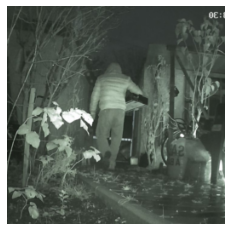

In [351]:
#choose you dataloader -> test_ &autocompletion
a_dataloader = test_valica_dataloader

model.eval()

images, labels = next(iter(a_dataloader))
helper.imshow(images[i].cpu(), normalize=False)


images = images.to(device)
labels = labels.to(device)

   
with torch.no_grad():
    output =  model.forward(images)
    proba = torch.exp(output)
    
print("It's a human at ", round(proba[i,0].item()*100,2), "%")

    

## Saving model on demand

In [310]:
#DON'T FORGOT TU NAME YOUR MODEL
model_name = "adam_0.01_ConstantinWarner_drop0.02"
torch.save(model.state_dict(), "trained_models/" + model_name)

## Load model on demand

In [321]:
#Which mode do you want to load ?
model_name = "adam_0.01_ConstantinWarner_drop0.02"
model.load_state_dict(torch.load("trained_models/" + model_name))

<All keys matched successfully>